# Mountain View Cemetary Open Data

One of my goals this year is to turn everything interesting I learn into a blog post. I've been using [Vancouver's open data](http://data.vancouver.ca/datacatalogue/) to find datasets to play around with, and the site includes some [data about people interred at Mountain View Cemetary](http://data.vancouver.ca/datacatalogue/mountainViewCemeteryBurialIndex.htm). A little morbid for a data vis exercise, but I'm doing it anyways.

<!-- TEASER_END-->

First, let's look at the dataset fields.

In [2]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('mvc_burial_index.csv')

In [4]:
df.columns

Index(['PersonId', 'LastName', 'FirstName', 'MaidenName', 'Alias', 'Age',
       'AgeType', 'DateOfBirth', 'PlaceOfBirth', 'DateOfDeath', 'PlaceOfDeath',
       'DateInterred', 'ReferenceNumberInter', 'DateDisinterred',
       'ReferenceNumberDisinter', 'Destination', 'SiteFullName', 'Lat', 'Lon'],
      dtype='object')

# Age at death

Let's looks at how old people are at their time of death. There's a big spike at age == 0 (~30% of all entries), big enough that I'm assuming missing values are coded as zeros. I'll ignore zero ages.

<IPython.core.display.Javascript object>


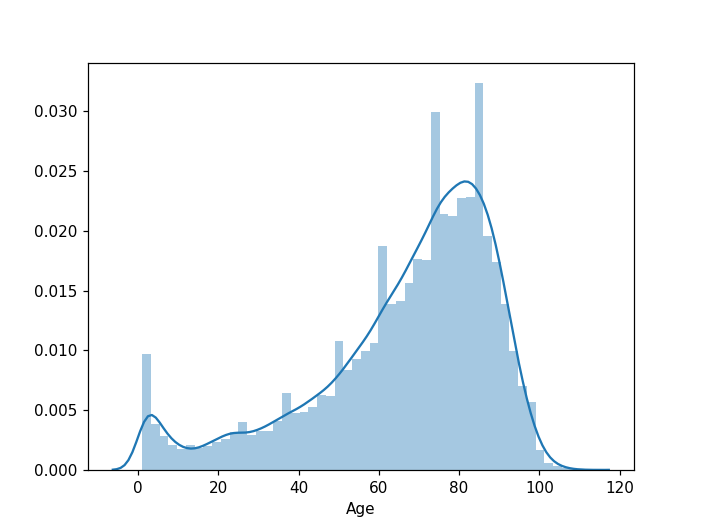

In [5]:
sns.distplot(df[df['Age']>0].loc[:,'Age']);

The bimodal distribtuion isn't surprising; A spike due to infant mortality, and a larger peak at old age. If I hadn't thrown out the zero ages the infant spike would have been larger, but there's no way to separate "true" zero ages from unknown ages.

# Age at death by burial year

I'm curious how this distribution changes year by year. Presumably people are living longer, will that show up in the data? Date interred is coded as a string, so I'll pull out the year as an integer and give it its own column.

In [6]:
def get_year_from_string(s):
    try:
        y = s.split('-')[0]
    except:
        y = np.nan
    return y

In [7]:
df['YearInterred'] = df['DateInterred'].map(get_year_from_string)

To visualize this, I'll plot a histogram of the number of burials each year to get a sense of how much data we're working with, and on top of that I'll plot the median age at death for people buried that year. The shaded area represents the 20th and 80th percentiles for each year to give us a sense of the spread in the data.

<IPython.core.display.Javascript object>


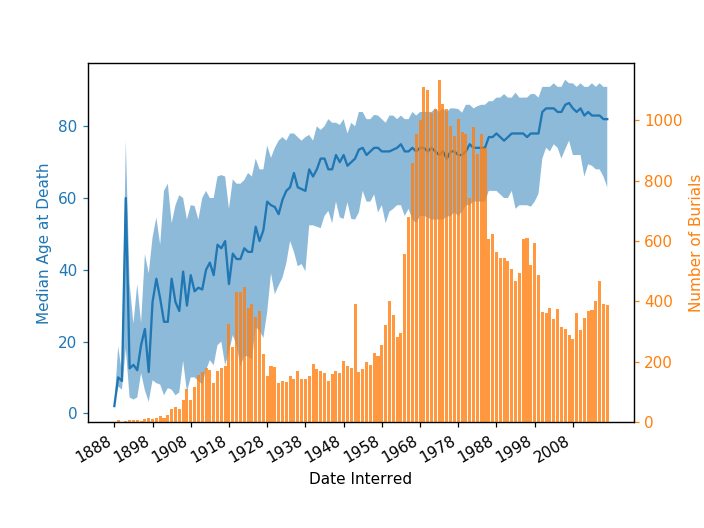

In [8]:
f,ax = plt.subplots()
ax2 = ax.twinx()

count_df = df[df['Age']>0].groupby('YearInterred').count().reset_index()
ax2.bar(count_df['YearInterred'],count_df['Age'],color=sns.color_palette()[1],alpha=0.8)
ax2.set_ylabel('Number of Burials',color=sns.color_palette()[1])

median_df = df[df['Age']>0].groupby('YearInterred').median().reset_index()
ax.plot(median_df['YearInterred'],median_df['Age'],color=sns.color_palette()[0])
q80_df = df[df['Age']>0].groupby('YearInterred').quantile(.8).reset_index()
q20_df = df[df['Age']>0].groupby('YearInterred').quantile(.2).reset_index()

ax.fill_between(median_df['YearInterred'],q20_df['Age'],q80_df['Age'],alpha=0.5)

ax.set_xlabel('Date Interred')
ax.set_ylabel('Median Age at Death',color=sns.color_palette()[0])
ax.set_xticks(median_df['YearInterred'][::10])
ax.set_xticklabels(median_df['YearInterred'][::10])
ax.tick_params('y',colors=sns.color_palette()[0])
ax2.tick_params('y',colors=sns.color_palette()[1])
f.autofmt_xdate()


There's a clear trend towards people dying older! I'm surprised by just how low the median age of death is prior to 1940. During the 1920s there's a pretty substantial sample but the median age is still just around 40. 

An interesting effect is seen by comparing the 80th percentile line to the 20th percentile line. The 90th percentile rises pretty consistently from 1900-1950, but the 20th percentile jumps dramatically in the 1930s. I wonder if this is a real effect due to healthcare improvements in that time. 

# Spatial distribution

Are old graves clustered, or spread out through the cemetary? Let's plot the plots and colour by date to see.

In [9]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches

In [10]:
def addgeo(shapef,ax,edgecolor='black',facecolor='white',alpha=0.5):
    shape = list(shpreader.Reader(shapef).geometries())
    record = list(shpreader.Reader(shapef).records())
    ax.add_geometries(shape, ccrs.epsg(26910),
                  edgecolor=edgecolor, facecolor=facecolor, alpha=alpha)
    return shape, record

<IPython.core.display.Javascript object>


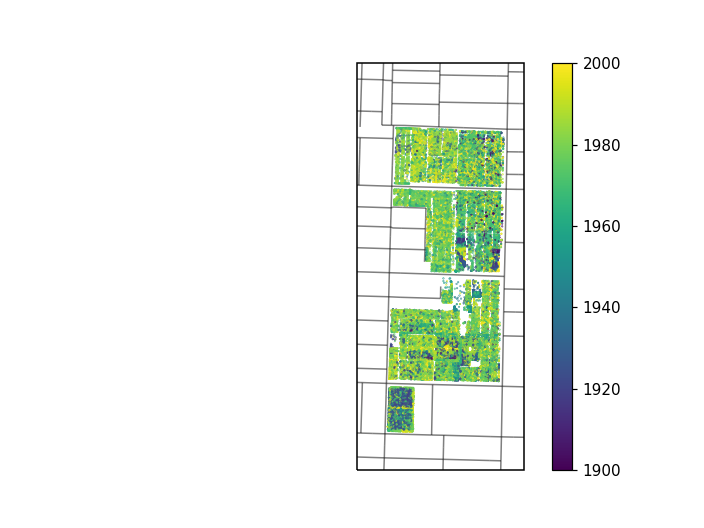

In [12]:
f, ax = plt.subplots()
ax = plt.axes(projection=ccrs.epsg(26910))

ax.set_extent([492800,493500,5453000,5454700 ], ccrs.epsg(26910))

coast,coastr = addgeo('/Users/msj/Dropbox/urban/maps/shoreline2002.shp',ax)
roads,roadsr = addgeo('/Users/msj/Dropbox/urban/maps/public_streets_MLINESTRING.shp',ax)

s = ax.scatter(df['Lon'],df['Lat'],
               transform=ccrs.PlateCarree(),
               s=0.1,
               c=df['YearInterred'],
               vmin=1900,
               vmax=2000)
f.colorbar(s);

There's a few clusters of old graves. The small area south of 41st ave looks to have a high density of of pre-1920 graves, along with the block near Fraser and 35th. According to <a href="https://en.wikipedia.org/wiki/Mountain_View_Cemetery_(Vancouver)">Wikipedia</a>, the block south of 41st was used for victims of the Spanish Influenza in 1918, and the area near Fraser and 35th is the original site of the cemetary.